## ATAC + MULTIOME FEMALES (july 2021)

### Convert to Seurat objects for CICERO

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.21.2
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

In [8]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [9]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_july2021/"
experiment_prefix = 'females_'

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [10]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 84631 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGranulosa', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max', 'leiden_R', 'leiden_2', 'cell_type', 'matching_barcode', 'somatic_annotation'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'individual_c

In [11]:
ATAC_scanpy.X

<84631x153356 sparse matrix of type '<class 'numpy.float32'>'
	with 272699508 stored elements in Compressed Sparse Row format>

In [12]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<84631x153356 sparse matrix of type '<class 'numpy.float32'>'
	with 272699508 stored elements in Compressed Sparse Row format>

In [13]:
binary_raw.shape

(84631, 153356)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [14]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [15]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7efcfb0f3800> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [16]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 153356  84631


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [17]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_46']
reduction_umap = ATAC_scanpy.obsm['X_umap']
reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [19]:
del ATAC_scanpy.obs['cellatac_clusters']

In [20]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [21]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:816774-817439" "chr1:817726-818992" "chr1:826596-827807"
[4] "chr1:869453-870256" "chr1:874940-875858" "chr1:876272-877438"
[1] "13-AAACAGCCAGCCAGAA-1" "13-AAACAGCCATCCAGGT-1" "13-AAACATGCATTGTCCT-1"
[4] "13-AAACCGAAGCTTCCCG-1" "13-AAACCGAAGGCGAATA-1" "13-AAACCGAAGTTCCTGC-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [22]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 153356 features for 84631 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [23]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
153356 features across 84631 samples within 1 assay 
Active assay: peaks (153356 features, 0 variable features)


In [24]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$cell_type))


  F81 Hrv11 Hrv12 Hrv13 Hrv39 Hrv49 Hrv50 Hrv58 Hrv59 Hrv65 Hrv91 Hrv92 
 8314  1157  3433  4760  1450  8620 20320  9601  5245  6761  3756 11214 

        GermCells           CoelEpi        Supporting      preGranulosa 
             9496              5575             12785             16541 
 Mesenchymal_LHX9 Mesenchymal_GATA2                PV              SMCs 
             8331             18408              5589               966 
           Immune       Endothelial        Epithelial            Neural 
             1069              3107              1801               963 


Step 5: Add dimensionality reductions to Seurat object 

In [25]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [26]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [27]:
%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

reduction_harmony_2 <- data.matrix(reduction_harmony)
key3 <- "Harmony_"
colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [28]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
153356 features across 84631 samples within 1 assay 
Active assay: peaks (153356 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


### Save RDS object of females 

In [29]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat, file = paste0(outdir, experiment_prefix, "_full.rds"))

In [30]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat <- readRDS(file = paste0(outdir, experiment_prefix, "_full.rds"))

## TF motifs with ChromVar

#### Add motifs

In [31]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}


# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
#print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
#print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

[1] 638 147 683


#### Add motifs

In [32]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
153356 features across 84631 samples within 1 assay 
Active assay: peaks (153356 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### Compute per-cell motif activity scores with chromVar

In [33]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
155276 features across 84631 samples within 2 assays 
Active assay: peaks (153356 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [34]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))

In [35]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [36]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [37]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$somatic_annotation
print(table(Idents(ATAC_Seurat_withChromVar)))


    CoelEpi_GATA2      CoelEpi_LHX9       Endothelial        Epithelial 
               39               908              3107              1801 
        GermCells                Gi            Immune Mesenchymal_GATA2 
             9496              3639              1069             18408 
           Neural               OSE                Oi                PV 
              963              4728              4852              5589 
             SMCs  early_supporting         granulosa           preGC_I 
              966              5787              1177              6567 
        preGC_IIa         preGC_IIb             sPAX8 
             8369              5721              1445 


In [38]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01h 03m 45s   |++                                                | 2 % ~01h 02m 20s   |++                                                | 3 % ~59m 09s       |+++                                               | 4 % ~55m 58s       |+++                                               | 5 % ~55m 26s       |++++                                              | 6 % ~53m 27s       |++++                                              | 7 % ~52m 38s       |+++++                                             | 8 % ~51m 55s       |+++++                                             | 9 % ~50m 37s       |++++++                                            | 10% ~49m 34s       |++++++                                            | 11% ~48m 51s       |+++++++                                           | 12% ~47m 52s       |+++++++                                           | 14% ~47m 

#### z-scores per cell type annotation

In [11]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 
ATAC_Seurat_withChromVar

An object of class Seurat 
155276 features across 84631 samples within 2 assays 
Active assay: chromvar (1920 features, 0 variable features)
 1 other assay present: peaks
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [12]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

In [13]:
chromvar_assay.shape

(84631, 1920)

In [14]:
# Mapping of cells to cell types 
ATAC_scanpy.obs['barcode'] = ATAC_scanpy.obs_names
cells_celltypes = ATAC_scanpy.obs[['barcode', 'somatic_annotation']]
cells_celltypes.head()

,barcode,somatic_annotation
13-AAACAGCCAGCCAGAA-1,13-AAACAGCCAGCCAGAA-1,GermCells
13-AAACAGCCATCCAGGT-1,13-AAACAGCCATCCAGGT-1,GermCells
13-AAACATGCATTGTCCT-1,13-AAACATGCATTGTCCT-1,GermCells
13-AAACCGAAGCTTCCCG-1,13-AAACCGAAGCTTCCCG-1,GermCells
13-AAACCGAAGGCGAATA-1,13-AAACCGAAGGCGAATA-1,GermCells


In [15]:
cells_mapping_clusters = cells_celltypes.groupby('somatic_annotation').groups

In [16]:
# Mean by rows 
for key in cells_mapping_clusters: 
    print(key)
    chromvar_assay.loc[key] = chromvar_assay.loc[cells_mapping_clusters[key]].mean(axis = 0)

CoelEpi_GATA2
CoelEpi_LHX9
Endothelial
Epithelial
GermCells
Gi
Immune
Mesenchymal_GATA2
Neural
OSE
Oi
PV
SMCs
early_supporting
granulosa
preGC_I
preGC_IIa
preGC_IIb
sPAX8


In [53]:
rows_celltypes = list(np.unique(cells_celltypes['somatic_annotation']))
print(rows_celltypes)
# Select only aggregated rows
chromvar_assay = chromvar_assay.loc[rows_celltypes, ]

['CoelEpi_GATA2', 'CoelEpi_LHX9', 'Endothelial', 'Epithelial', 'GermCells', 'Gi', 'Immune', 'Mesenchymal_GATA2', 'Neural', 'OSE', 'Oi', 'PV', 'SMCs', 'early_supporting', 'granulosa', 'preGC_I', 'preGC_IIa', 'preGC_IIb', 'sPAX8']


In [54]:
# Normalize by column (TF)
from scipy.stats import zscore
chromvar_assay_zscore = chromvar_assay.apply(zscore)

In [55]:
chromvar_assay_zscore.to_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv")

In [12]:
chromvar_assay_zscore = pd.read_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv", index_col = 0)

In [13]:
chromvar_assay_zscore = chromvar_assay_zscore.reindex(['GermCells',
                                                'CoelEpi_GATA2', 'CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I',
                                                 'OSE','preGC_IIa', 'preGC_IIb', 'granulosa',
                                                  'Oi',  'Gi', 
                                                 'Mesenchymal_GATA2', 
                                                 'PV', 'SMCs', 'Endothelial', 'Immune', 'Epithelial', 'Neural'
                                          ])


In [27]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, s = 100, l = 40,n=10, as_cmap=True)
sns.set(font_scale=1.4)

In [68]:
chromvar_assay_zscore.shape

(19, 1920)

In [69]:
chromvar_assay_zscore

,NFIL3.MA0025.1,FOXF2.MA0030.1,FOXD1.MA0031.1,IRF2.MA0051.1,MZF1.MA0056.1,MZF1(var.2).MA0057.1,MAX::MYC.MA0059.1,PPARG.MA0066.1,Pax6.MA0069.1,PBX1.MA0070.1,...,ZNF416.HOMER,ZNF41.HOMER,ZNF467.HOMER,ZNF519.HOMER,ZNF528.HOMER,ZNF669.HOMER,ZNF675.HOMER,ZNF692.HOMER,ZNF711.HOMER,ZSCAN22.HOMER
GermCells,0.569555,0.657433,0.647987,0.557716,0.657341,0.095479,1.274483,-0.242001,0.096501,0.991222,...,1.313305,-0.092463,-1.715204,2.009364,-0.059981,0.077435,2.489409,2.962312,2.498878,1.819024
CoelEpi_GATA2,0.921532,-0.030894,-0.222533,-0.153900,1.420248,0.354542,0.841481,-0.428369,0.367537,0.197547,...,-0.758619,0.402608,1.051922,0.486469,0.243620,-0.265085,0.997614,1.020985,0.875223,0.812218
CoelEpi_LHX9,0.312640,-1.384440,-1.261430,-0.561369,-0.200984,0.527011,-0.735503,-1.377438,0.243087,0.161923,...,-0.428240,-0.990885,1.542352,-0.230296,-0.609363,-1.064671,-1.067926,0.077109,1.056170,0.693654
early_supporting,-0.773840,0.583714,0.495064,-0.306277,-0.040486,-0.401016,-0.520460,0.145609,-0.304419,0.366665,...,-0.243354,-0.023093,1.068119,0.236491,-0.140809,-0.169569,0.788215,0.178162,-0.566455,0.316223
sPAX8,-0.771623,-0.085077,-0.020983,-0.487917,-0.742157,-0.104580,-0.365948,-0.851765,1.217941,0.367598,...,-0.835786,-0.185001,0.267334,-0.402651,-0.679720,-0.559687,-0.808103,0.033137,-0.351495,-0.096387
preGC_I,-1.421531,1.309991,1.324087,-0.134873,-1.355984,-1.407501,-0.736581,-0.324725,-0.817907,-0.587804,...,-1.114191,-1.369523,-1.532976,-0.500549,-1.165697,-0.660531,-0.334718,-0.332821,-0.879687,-0.594936
OSE,-1.177253,-1.569837,-1.447207,-1.324212,-1.238458,-0.519560,-1.604476,0.679022,-0.501138,0.562187,...,-0.417222,-0.301266,-0.523846,-1.810463,-0.955000,-0.920857,-0.981267,-0.939278,0.214858,-0.562897
preGC_IIa,-1.635616,-0.874165,-0.877826,-1.864639,-0.988013,-1.177662,-1.382271,1.511472,-0.894006,0.780172,...,-0.360288,-0.483632,-0.040628,-1.566781,-1.061895,-0.737602,-0.545364,-0.905569,-0.379338,-0.694136
preGC_IIb,-1.192152,1.285925,1.248618,-1.066416,-1.103564,-1.614286,-1.317551,1.970750,-1.203137,0.013687,...,-0.563141,0.046367,-0.369505,-1.193770,-0.939445,-0.612920,-0.661874,-1.027350,0.457156,-0.646734
granulosa,-0.731198,2.654486,2.674092,0.297571,-0.976841,-1.491276,-1.053957,1.562240,-1.236790,-0.738642,...,0.391514,-0.139796,0.133497,-0.423315,-0.717933,0.160286,0.128330,-0.964790,1.039923,0.103282


/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


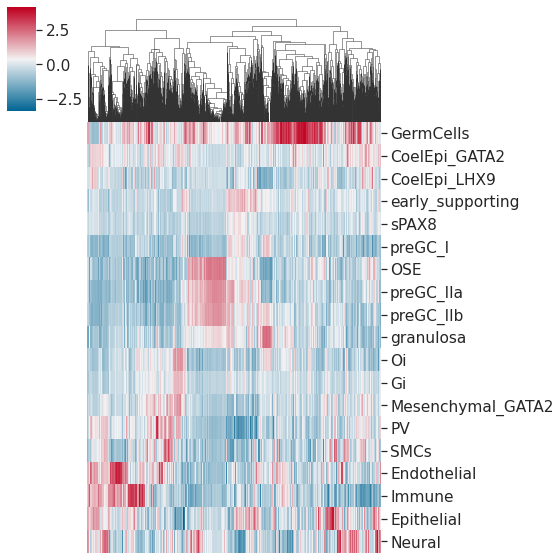

In [70]:
heatmap_TFs = sns.clustermap(chromvar_assay_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_july2021/figures_females/heatmap_females_TFs.pdf")


### Select top 3 TFs per cell type 

In [87]:
top_tfs = []
for c in chromvar_assay_zscore.index:
    df_c = chromvar_assay_zscore.loc[c]
    df_c = df_c.sort_values(axis = 0, ascending = False)
    top_4 = df_c[0:6].index
    top_tfs.extend(top_4)

In [88]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore[top_tfs]

In [89]:
chromvar_assay_zscore_top4.columns[100:130]

Index(['RUNX2.SwissRegulon', 'IRF1.SwissRegulon', 'GRHL1.SwissRegulon',
       'GRHL1-HUMAN.H10MO.D', 'HNF1B.SwissRegulon', 'HNF1B.MA0153.2',
       'GRHL2.MA1105.1', 'GRHL1.MA0647.1', 'RFX3.SwissRegulon',
       'RFX2.SwissRegulon', 'RFX3-HUMAN.H10MO.B', 'RFX4-HUMAN.H10MO.D',
       'RFX2.MA0600.2', 'SOX17-HUMAN.H10MO.D'],
      dtype='object')

In [90]:
to_plot = ['NFYB.SwissRegulon', 'TFAP2D.SwissRegulon','KAISO-HUMAN.H10MO.A',
           'PTF1A-HUMAN.H10MO.C','MEIS1-HUMAN.H10MO.C','GLIS3.SwissRegulon',
           'PROX1-HUMAN.H10MO.D','ZNF281.SwissRegulon','HOXB5.SwissRegulon',
       'PKNOX2.MA0783.1', 'TGIF2LX.SwissRegulon', 'TBX19.MA0804.1', 
       'PAX1.MA0779.1', 'PAX9.MA0781.1',  'EGR1.SwissRegulon',
           'FOXA1.HOMER','FOXO3.SwissRegulon',  'FOXD1.MA0031.1',
           'LHX2-HUMAN.H10MO.D','MNX1.SwissRegulon', 'DLX2.SwissRegulon',
           'EVX1.SwissRegulon', 'VAX1.MA0722.1',  'VSX1.SwissRegulon',
       'ESR2.MA0258.2',  'NOTO.MA0710.1', 'FOXB1.SwissRegulon',
           'FOXO3.SwissRegulon',  'FOXF2.MA0030.1',
           'MSC.MA0665.1',  'ZBTB18.MA0698.1', 'TAL1-HUMAN.H10MO.S',
           'OLIG1.MA0826.1', 'NEUROD1.SwissRegulon', 'BHE23-HUMAN.H10MO.D',
           'TWIST1.MA1123.1',  'BHA15-HUMAN.H10MO.D', 'OLIG2-HUMAN.H10MO.D',
       'EBF1.MA0154.3', 'EBF3.SwissRegulon','RBPJ.SwissRegulon',
           'SRF.MA0083.3',  'HSF4.MA0771.1', 'HSF1.MA0486.2',
           'FLI1.SwissRegulon',  'EHF.SwissRegulon', 'FEV-HUMAN.H10MO.C',
           'SPI1.MA0080.4', 'SPIC.SwissRegulon', 'SPIB-HUMAN.H10MO.B',
           'HNF1B.SwissRegulon', 'GRHL1.SwissRegulon', 'GRHL2.MA1105.1',
           'RFX3.SwissRegulon', 'RFX2.SwissRegulon',  'RFX4-HUMAN.H10MO.D',
           ]
len(to_plot)

56

In [91]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore_top4[to_plot]
chromvar_assay_zscore_top4.columns

Index(['NFYB.SwissRegulon', 'TFAP2D.SwissRegulon', 'KAISO-HUMAN.H10MO.A',
       'PTF1A-HUMAN.H10MO.C', 'MEIS1-HUMAN.H10MO.C', 'GLIS3.SwissRegulon',
       'PROX1-HUMAN.H10MO.D', 'ZNF281.SwissRegulon', 'HOXB5.SwissRegulon',
       'PKNOX2.MA0783.1', 'TGIF2LX.SwissRegulon', 'TGIF2LX.SwissRegulon',
       'TBX19.MA0804.1', 'TBX19.MA0804.1', 'PAX1.MA0779.1', 'PAX9.MA0781.1',
       'EGR1.SwissRegulon', 'FOXA1.HOMER', 'FOXO3.SwissRegulon',
       'FOXO3.SwissRegulon', 'FOXD1.MA0031.1', 'FOXD1.MA0031.1',
       'LHX2-HUMAN.H10MO.D', 'MNX1.SwissRegulon', 'DLX2.SwissRegulon',
       'EVX1.SwissRegulon', 'VAX1.MA0722.1', 'VSX1.SwissRegulon',
       'ESR2.MA0258.2', 'NOTO.MA0710.1', 'FOXB1.SwissRegulon',
       'FOXO3.SwissRegulon', 'FOXO3.SwissRegulon', 'FOXF2.MA0030.1',
       'MSC.MA0665.1', 'MSC.MA0665.1', 'ZBTB18.MA0698.1', 'TAL1-HUMAN.H10MO.S',
       'OLIG1.MA0826.1', 'NEUROD1.SwissRegulon', 'NEUROD1.SwissRegulon',
       'BHE23-HUMAN.H10MO.D', 'TWIST1.MA1123.1', 'BHA15-HUMAN.H10MO.D',
 

In [92]:
chromvar_assay_zscore_top4.columns = [col.split(".")[0] for col in chromvar_assay_zscore_top4.columns]
chromvar_assay_zscore_top4.columns = [col.split("-")[0] for col in chromvar_assay_zscore_top4.columns]

In [93]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore_top4.loc[:,~chromvar_assay_zscore_top4.columns.duplicated()]

In [94]:
chromvar_assay_zscore_top4.shape

(19, 55)

In [95]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


<ipython-input-95-63a9665b3b7d>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


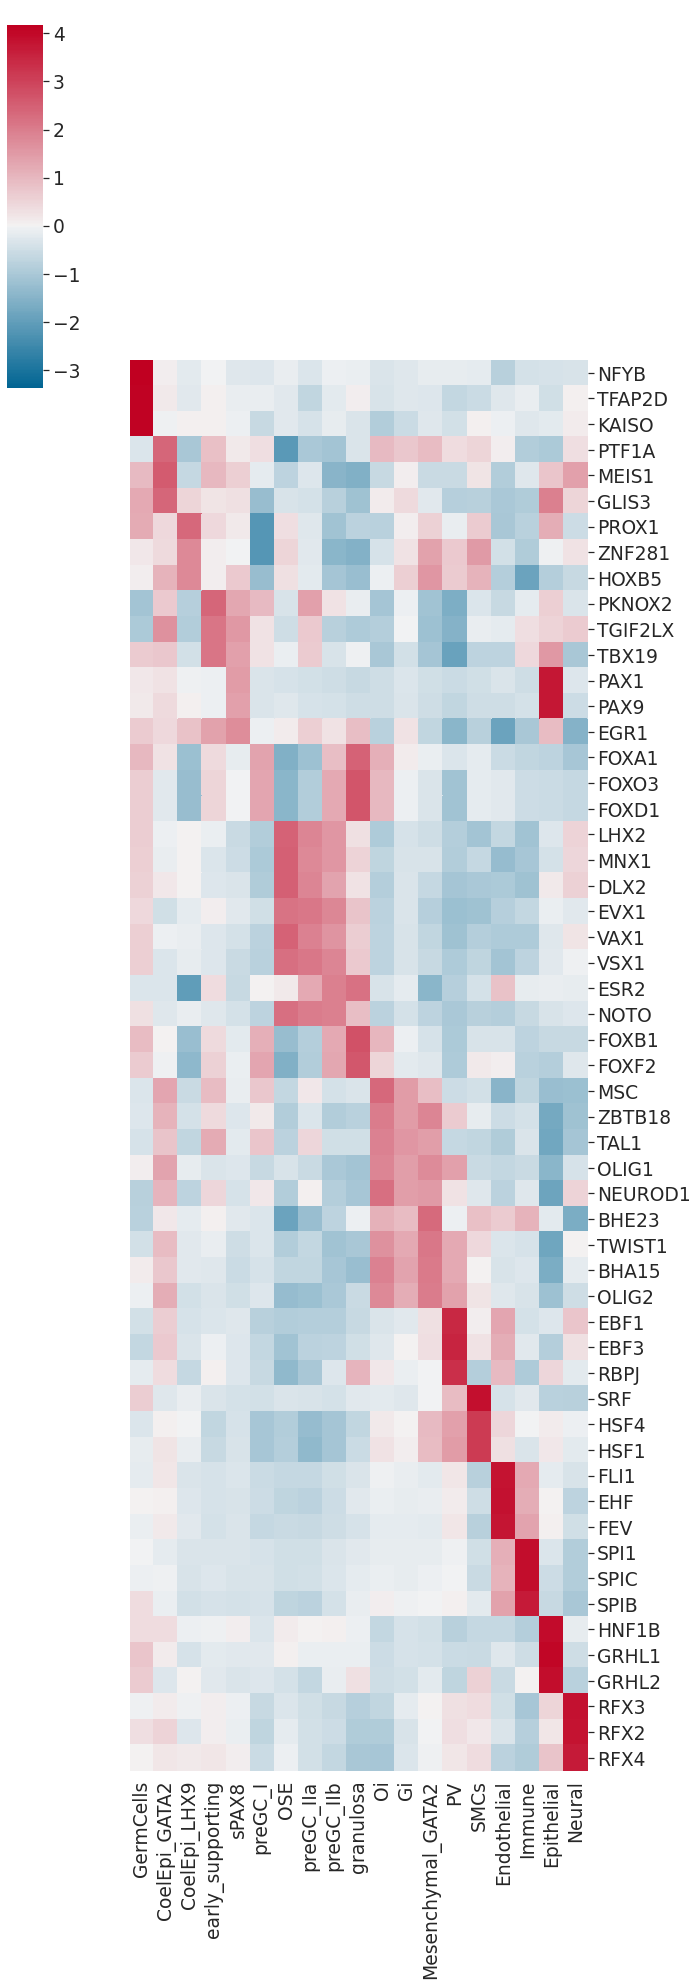

In [103]:
sns.set(font_scale=1.7)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_top4, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(10, 28),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_july2021/figures_females/heatmap_females_TFs_top3_curated.pdf")


### Plot TFs associated with DSD

In [59]:
dsd_tfs = ['ARX', 'ATRX', 'BMP15', 'CBX2', 'DAX1', 'DHH', 'DHX37', 'DMRT1', 'EMX2', 'ESR2', 'FGF9', 'FGFR2', 'FOXL2',
          'GATA4', 'HHAT', 'MAP3K1', 'NR2F2', 'NR5A1', 'NUP107', 'RSPO1', 'SOX3', 'SOX8', 'SOX9', 'SOX10', 'SRY', 
          'STARD8', 'TSPYL1', 'WNT4', 'WT1', 'WWOX', 'ZFPM2', 'ZNRF3']

In [83]:
df = pd.DataFrame(chromvar_assay_zscore.columns)

In [85]:
df[0][df[0].str.contains('|'.join(dsd_tfs))]


14            SOX9.MA0077.1
16             SRY.MA0084.1
62            ESR2.MA0258.2
338           SOX8.MA0868.1
343          BARX1.MA0875.1
348           EMX2.MA0886.1
393          NR2F2.MA1111.1
404          SOX10.MA0442.2
467       ARX-HUMAN.H10MO.D
478     BARX1-HUMAN.H10MO.D
479     BARX2-HUMAN.H10MO.D
561      EMX2-HUMAN.H10MO.D
571      ESR2-HUMAN.H10MO.A
572      ESR2-HUMAN.H10MO.S
627     GATA4-HUMAN.H10MO.B
958     SOX10-HUMAN.H10MO.D
967      SOX3-HUMAN.H10MO.D
971      SOX8-HUMAN.H10MO.D
972      SOX9-HUMAN.H10MO.B
986       SRY-HUMAN.H10MO.B
1049      WT1-HUMAN.H10MO.D
1102       ARX.SwissRegulon
1116     BARX1.SwissRegulon
1117     BARX2.SwissRegulon
1199      EMX2.SwissRegulon
1208      ESR2.SwissRegulon
1265     GATA4.SwissRegulon
1502     NR2F2.SwissRegulon
1624     SOX10.SwissRegulon
1635     SOX30.SwissRegulon
1636      SOX3.SwissRegulon
1641      SOX8.SwissRegulon
1642      SOX9.SwissRegulon
1656       SRY.SwissRegulon
1724       WT1.SwissRegulon
1791            DMRT

In [96]:
dsd_tfs_present = ['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon', 'ESR2.SwissRegulon',
                  'GATA4.SwissRegulon', 'FOXL2.HOMER',
                  'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 
                   'SOX8-HUMAN.H10MO.D', 'SOX9.SwissRegulon', 
                  'SOX10.SwissRegulon', 'SRY.SwissRegulon', 
                  'WT1-HUMAN.H10MO.D']


In [97]:
chromvar_assay_zscore_DSD = chromvar_assay_zscore[dsd_tfs_present]
chromvar_assay_zscore_DSD.columns

Index(['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon',
       'ESR2.SwissRegulon', 'GATA4.SwissRegulon', 'FOXL2.HOMER',
       'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 'SOX8-HUMAN.H10MO.D',
       'SOX9.SwissRegulon', 'SOX10.SwissRegulon', 'SRY.SwissRegulon',
       'WT1-HUMAN.H10MO.D'],
      dtype='object')

In [98]:
chromvar_assay_zscore_DSD.columns = [col.split(".")[0] for col in chromvar_assay_zscore_DSD.columns]
chromvar_assay_zscore_DSD.columns = [col.split("-")[0] for col in chromvar_assay_zscore_DSD.columns]


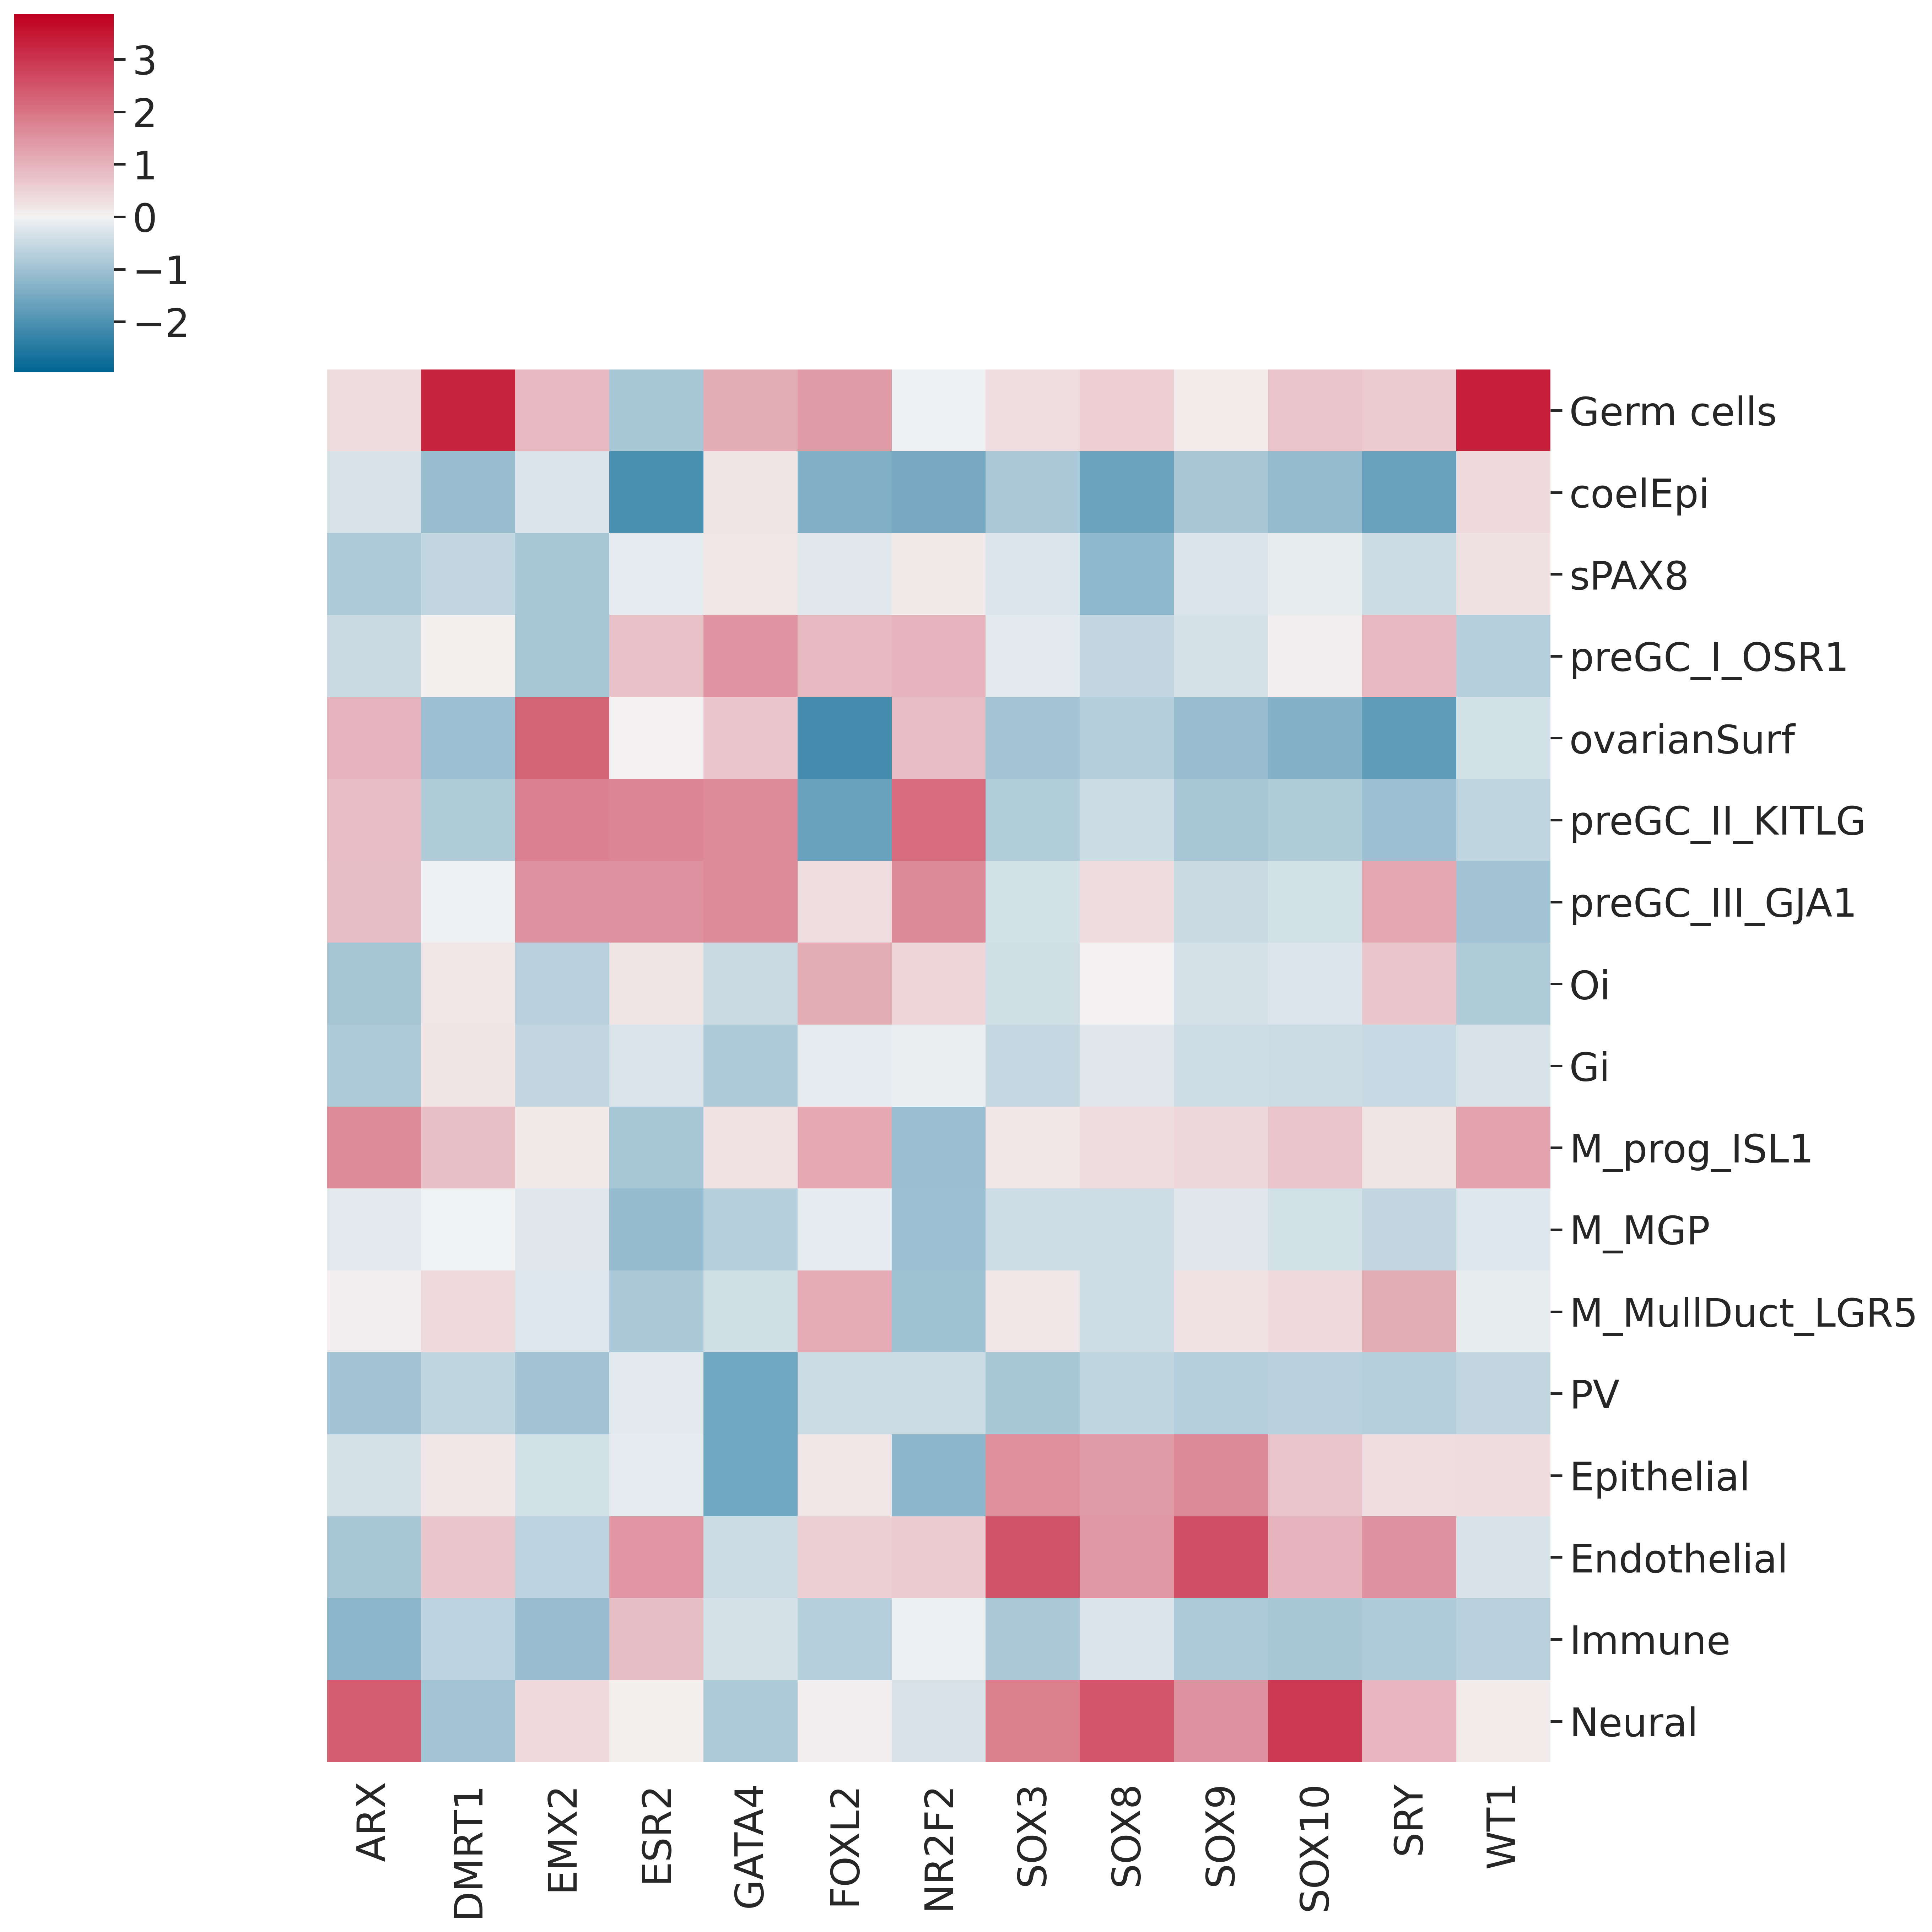

In [99]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_DSD, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(14, 14),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_females/DSD_TFs_heatmap.pdf")


#### End of notebook